In [1]:
# Standard imports for data analysis packages in Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# This enables inline Plots
%matplotlib inline

# Limit rows displayed in notebook
pd.set_option('display.max_rows', 10)
pd.set_option('display.precision', 2)

In [2]:
'''
Goals for this file:
1- prepare .csv in manner similar to lin regression file -- discussing differences in specification
2- run Random Forest of regression trees to see if we can get a more accurate result
'''

'\nGoals for this file:\n1- prepare .csv in manner similar to lin regression file -- discussing differences in specification\n2- run Random Forest of regression trees to see if we can get a more accurate result\n'

In [2]:
df = pd.read_csv('saleprice_df.csv')

In [9]:
# drop variables we definitely won't be using -- address, some identifiers
df_held = pd.DataFrame(df['NBHD_1_CN_x'])

df_f1 = df.drop(['SITE_NBR', 'SITE_DIR', 'SITE_NAME', 'SITE_MODE', 'SITE_MORE','NBHD_1_x', 'RECEPTION_NUM', 
                    'SCHEDNUM', 'Unnamed: 0'], axis=1)

In [10]:
df_held

,NBHD_1_CN_x
0,N GREEN VALLEY
1,N GREEN VALLEY
2,N GREEN VALLEY
3,N GREEN VALLEY
4,N GREEN VALLEY
...,...
56100,GRANT RN/MARST
56101,GRANT RN/MARST
56102,GRANT RN/MARST
56103,GRANT RN/MARST


In [11]:
z1 = list(df_held.NBHD_1_CN_x.value_counts()[:25].index)

df_held['NBHD_short'] = np.where(df_held['NBHD_1_CN_x'].isin(z1), df_held['NBHD_1_CN_x'], 'Other')

df_andhood = pd.get_dummies(df_held['NBHD_short'], prefix='NBHD_name')

df_f1a = pd.concat([df_f1, df_andhood], axis=1)

In [12]:
# Transform variables in the form we want

df_f1a['SALES_YR'] = df_f1a['RECEPTION_DATE'].map(lambda x : str(x)[:4]).astype('int')
df_f1a['SALES_MONTH'] = df_f1a['RECEPTION_DATE'].map(lambda x : str(x)[4:6]).astype('str')
df_f1a['RECENT_RENO'] = np.where(df_f1a['CCAGE_RM'] >= 2000, 1, 0)
df_f1a['HOME_AGE'] = 2015 - df_f1a.CCYRBLT

df_f2 = df_f1a.drop(['RECEPTION_DATE', 'CCAGE_RM', 'CCYRBLT'], axis=1)

df_f2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56105 entries, 0 to 56104
Data columns (total 46 columns):
INSTRUMENT                   56105 non-null object
CLASS                        56105 non-null object
D_CLASS                      56105 non-null int64
NBHD_1_CN_x                  56105 non-null object
OFCARD                       56105 non-null float64
TAX_DIST                     56105 non-null object
LAND_SQFT                    56076 non-null float64
AREA_ABG                     56105 non-null float64
BSMT_AREA                    56105 non-null float64
FBSMT_SQFT                   56105 non-null float64
GRD_AREA                     56105 non-null float64
STORY                        56105 non-null float64
BED_RMS                      56105 non-null float64
FULL_B                       56083 non-null float64
HLF_B                        56083 non-null float64
SALE_PRICE                   56105 non-null float64
NBHD_name_ATHMAR PARK        56105 non-null float64
NBHD_name_BAR

In [13]:
# Next, we impute some missing values for LAND_SQFT, FULL_B, HLF_B, and HOME_AGE
col_dist = {}
def get_col_dist(col_name):
    excl_null_mask = df_f2[col_name].notnull()
    row_count = df_f2[excl_null_mask][col_name].size
    col_data = {}
    col_data['prob'] = (df_f2[excl_null_mask][col_name].value_counts() / row_count).values
    col_data['values'] = (df_f2[excl_null_mask][col_name].value_counts() / row_count).index.values
    return col_data


col_dist['FULL_B'] = get_col_dist('FULL_B')
col_dist['HLF_B'] = get_col_dist('HLF_B')
col_dist['HOME_AGE'] = get_col_dist('HOME_AGE')


def impute_cols(val, options):
    if np.isnan(val):
        return np.random.choice(options['values'], p=options['prob'])
    return val

def impute_FULL_B(val):
    return impute_cols(val, col_dist['FULL_B'])

def impute_HLF_B(val):
    return impute_cols(val, col_dist['HLF_B'])

def impute_HOME_AGE(val):
    return impute_cols(val, col_dist['HOME_AGE'])

df_f2['FULL_B_imp'] = df_f2.FULL_B.map(impute_FULL_B)
df_f2['HLF_B_imp'] = df_f2.HLF_B.map(impute_HLF_B)
df_f2['HOME_AGE_imp'] = df_f2.HOME_AGE.map(impute_HOME_AGE)

In [14]:
def impute_numeric_cols(col_data, col_name):
    na_row_count = col_data.isnull().sum()
    impute_vals = np.random.normal(col_data.mean(), col_data.std(), na_row_count)
    return impute_vals

LAND_SQFT_rows_mask = df_f2['LAND_SQFT'].isnull()
df_f2.loc[LAND_SQFT_rows_mask, 'LAND_SQFT'] = impute_numeric_cols(df_f2['LAND_SQFT'], 'LAND_SQFT')

df_f3 = df_f2.drop(['FULL_B','HLF_B','HOME_AGE'], axis=1)

In [15]:
# Now we transform our categories into dummy variables

cat_var = ['INSTRUMENT', 'CLASS', 'D_CLASS', 'OFCARD', 'TAX_DIST', 'STORY', 'SALES_MONTH']
# Although we turned SALES_YEAR into dummies last time, for the purposes of a regression tree, I think it's worth looking at
# whether we can use it to set a threshold in time, rather than as independent categories.
# We're going to ignore Neighborhood ('NBHD_1_CN_x') for now...

df_cat = df_f3[cat_var]
# But they need to be strings for pd.get_dummies, so:
df_cat['D_CLASS_s'] = df_cat['D_CLASS'].astype('str')
df_cat['OFCARD_s'] = df_cat['OFCARD'].astype('str')
df_cat['STORY_s'] = df_cat['STORY'].astype('str')

df_cat.drop(['D_CLASS', 'OFCARD', 'STORY'], axis=1)
df_catd = pd.get_dummies(df_cat, dummy_na=True)

-c:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
df_catd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56105 entries, 0 to 56104
Data columns (total 85 columns):
D_CLASS            56105 non-null int64
OFCARD             56105 non-null float64
STORY              56105 non-null float64
INSTRUMENT_AD      56105 non-null float64
INSTRUMENT_AF      56105 non-null float64
INSTRUMENT_BG      56105 non-null float64
INSTRUMENT_BS      56105 non-null float64
INSTRUMENT_CD      56105 non-null float64
INSTRUMENT_CS      56105 non-null float64
INSTRUMENT_DD      56105 non-null float64
INSTRUMENT_DE      56105 non-null float64
INSTRUMENT_DF      56105 non-null float64
INSTRUMENT_GR      56105 non-null float64
INSTRUMENT_PR      56105 non-null float64
INSTRUMENT_PT      56105 non-null float64
INSTRUMENT_RC      56105 non-null float64
INSTRUMENT_SC      56105 non-null float64
INSTRUMENT_SF      56105 non-null float64
INSTRUMENT_SW      56105 non-null float64
INSTRUMENT_TR      56105 non-null float64
INSTRUMENT_WD      56105 non-null float64
INSTRUMENT_

In [17]:
df_f4 = pd.concat([df_f3, df_catd], axis=1)
df_f5 = df_f4.drop(df_f4[cat_var], axis=1)

### Now we can build our model

In [18]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split

In [21]:
X = df_f5.drop(['SALE_PRICE', 'NBHD_1_CN_x'], axis=1)
y = df_f5['SALE_PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=36)

In [22]:
y_train.size

33663

In [23]:
%%time
rf_10 = RandomForestRegressor(n_estimators=20, oob_score=True, n_jobs=2, random_state=36)

Wall time: 0 ns


In [24]:
%%time
rf_10.fit(X_train, y_train)

Wall time: 13 s


C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:659: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=2, oob_score=True, random_state=36,
           verbose=0, warm_start=False)

In [25]:

%%time
cross_val_score(rf_10, X_train, y_train, cv=3)

Wall time: 32.5 s


array([ 0.87081523,  0.95992888,  0.95174246])

In [26]:
%%time
print rf_10.score(X_test, y_test)

y_pred = rf_10.predict(X_test)

0.888812671376
Wall time: 900 ms


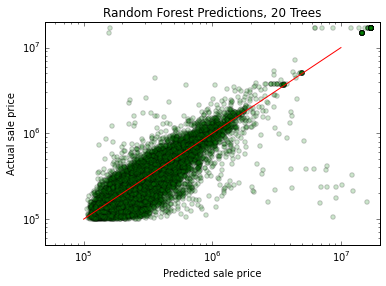

In [27]:
# much better!
x = range(100000,10000000,10000)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(x, x, c='r')

ax.scatter(y_pred, y_test, c='g', alpha=0.2)
ax.set_xlabel('Predicted sale price')
ax.set_ylabel('Actual sale price')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([50000, 20000000])
ax.set_ylim([50000, 20000000])

ax.set_title('Random Forest Predictions, 20 Trees')

fig.savefig("forest20.png")

In [28]:
sorted(zip(rf_10.feature_importances_, X.columns), reverse=True)[:20]

[(0.28778949771799178, 'SALES_YR'),
 (0.26718119302164223, 'SALES_MONTH_12'),
 (0.086834702680442369, 'HOME_AGE_imp'),
 (0.074465129914730005, 'SALES_MONTH_03'),
 (0.046716133681352467, 'INSTRUMENT_WD'),
 (0.039021105338390413, 'NBHD_name_PARKFIELD'),
 (0.031066313732207418, 'AREA_ABG'),
 (0.029555107618653969, 'TAX_DIST_151T'),
 (0.026091646754007537, 'INSTRUMENT_SW'),
 (0.023127894737120774, 'BSMT_AREA'),
 (0.022320043945196179, 'TAX_DIST_151D'),
 (0.01107941026519693, 'NBHD_name_N GREEN VALLEY'),
 (0.01032999880037863, 'LAND_SQFT'),
 (0.0087339178612906819, 'NBHD_name_W WASHINGTON PK'),
 (0.0056132182305600013, 'D_CLASS_s_113'),
 (0.0052446767725816221, 'FBSMT_SQFT'),
 (0.0049724802170257477, 'INSTRUMENT_BS'),
 (0.0022935650723502517, 'TAX_DIST_DENVER'),
 (0.0019093384567376481, 'TAX_DIST_111E'),
 (0.0016156109163946858, 'RECENT_RENO')]

#### Now, we scale it up

In [29]:
rf_50 = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=36)

In [30]:
%%time
rf_50.fit(X_train, y_train)

Wall time: 4min 31s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=36,
           verbose=0, warm_start=False)

In [31]:
%%time
#print '3-fold cross-val score', cross_val_score(rf_50, X_train, y_train)

print 'test data score', rf_50.score(X_test, y_test)


test data score 0.894672261838
Wall time: 3.19 s


(50000, 20000000)

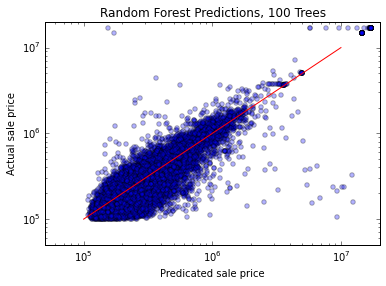

In [33]:
# So didn't realize gains from more trees
y_pred50 = rf_50.predict(X_test)


fig, ax = plt.subplots(1, 1)
ax.plot(x, x, c='r')

ax.scatter(y_pred50, y_test, c='b', alpha=0.3)
ax.set_xlabel('Predicated sale price')
ax.set_ylabel('Actual sale price')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Random Forest Predictions, 100 Trees')
ax.set_xlim([50000, 20000000])
ax.set_ylim([50000, 20000000])

In [34]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, y_pred50)

0.89467324083240818

In [35]:
sorted(zip(rf_50.feature_importances_, X.columns), reverse=True)[:20]

[(0.31020468694955311, 'SALES_YR'),
 (0.26752350584138829, 'SALES_MONTH_12'),
 (0.092216562802871938, 'HOME_AGE_imp'),
 (0.079363300754790492, 'SALES_MONTH_03'),
 (0.038711843891194683, 'NBHD_name_PARKFIELD'),
 (0.033984462677462829, 'INSTRUMENT_WD'),
 (0.032395580218060889, 'AREA_ABG'),
 (0.026160433650428718, 'BSMT_AREA'),
 (0.019945822665595195, 'TAX_DIST_151T'),
 (0.017547996348531433, 'TAX_DIST_151D'),
 (0.016837292610564235, 'INSTRUMENT_SW'),
 (0.010978110114383932, 'NBHD_name_N GREEN VALLEY'),
 (0.008803549051841688, 'LAND_SQFT'),
 (0.0072266751657027286, 'NBHD_name_W WASHINGTON PK'),
 (0.0061950148503061844, 'D_CLASS_s_113'),
 (0.005251274953061145, 'FBSMT_SQFT'),
 (0.0040526293713195986, 'INSTRUMENT_BS'),
 (0.003167470831742859, 'TAX_DIST_DENVER'),
 (0.0024415510443330695, 'D_CLASS_s_114'),
 (0.0018571052623772041, 'TAX_DIST_111E')]

#### Quick K-nearest-neighbors for comparison

In [36]:
df_knn = df_f3.drop(['INSTRUMENT', 'CLASS', 'D_CLASS', 'NBHD_1_CN_x', 'OFCARD', 'TAX_DIST'], axis=1)

df_knn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56105 entries, 0 to 56104
Data columns (total 40 columns):
LAND_SQFT                    56105 non-null float64
AREA_ABG                     56105 non-null float64
BSMT_AREA                    56105 non-null float64
FBSMT_SQFT                   56105 non-null float64
GRD_AREA                     56105 non-null float64
STORY                        56105 non-null float64
BED_RMS                      56105 non-null float64
SALE_PRICE                   56105 non-null float64
NBHD_name_ATHMAR PARK        56105 non-null float64
NBHD_name_BARNUM             56105 non-null float64
NBHD_name_BERKELEY           56105 non-null float64
NBHD_name_CORY MERRILL       56105 non-null float64
NBHD_name_GREEN VALLEY       56105 non-null float64
NBHD_name_HALE/MAYFAIR       56105 non-null float64
NBHD_name_HARVEY PARK        56105 non-null float64
NBHD_name_LOWRY              56105 non-null float64
NBHD_name_MAR LEE            56105 non-null float64
NBHD_na

In [37]:
Xk = df_knn.drop(['SALE_PRICE'], axis=1)
yk = df_knn['SALE_PRICE']

In [38]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import scale

Xk2 = scale(np.array(Xk.values))

In [40]:
Xk_train, Xk_test, yk_train, yk_test = train_test_split(Xk2, yk, test_size=0.4, random_state=36)

knn_mod = KNeighborsRegressor(n_neighbors=6, weights='distance')

In [41]:
%%time
knn_mod.fit(Xk_train, yk_train)
yk_pred = knn_mod.predict(Xk_test)

Wall time: 2min 43s


In [44]:
%%time

print 'test data score', knn_mod.score(Xk_test, yk_test)

test data score 0.708599832614
Wall time: 2min 54s


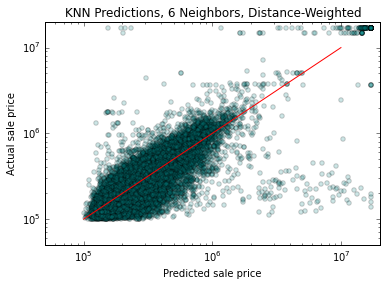

In [45]:
x = range(100000,10000000,10000)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(x, x, c='r')

ax.scatter(yk_pred, yk_test, c='teal', alpha=0.2)
ax.set_xlabel('Predicted sale price')
ax.set_ylabel('Actual sale price')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([50000, 20000000])
ax.set_ylim([50000, 20000000])

ax.set_title('KNN Predictions, 6 Neighbors, Distance-Weighted')

fig.savefig("KNN6.png")

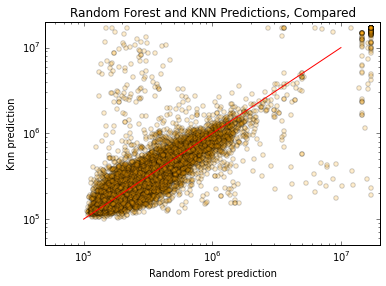

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(x, x, c='r')

ax.scatter(y_pred, yk_pred, c='orange', alpha=0.2)
ax.set_xlabel('Random Forest prediction')
ax.set_ylabel('Knn prediction')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([50000, 20000000])
ax.set_ylim([50000, 20000000])

ax.set_title('Random Forest and KNN Predictions, Compared')

fig.savefig("RFvsKNN.png")